In [122]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
mimic_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\processed\\mimic-iii-clinical-database-1.4"

## Explore patient information

In [100]:
patients = pd.read_parquet(join(mimic_path,"patients_info.parquet"))
print(patients.GENDER.value_counts())
print(patients.DEATHDATE.notnull().sum(), 'dead patients')
cat_cols = ['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
# for col in cat_cols:
    # patients[col] = patients[col].astype('category')

M    26121
F    20399
Name: GENDER, dtype: int64
15759 dead patients


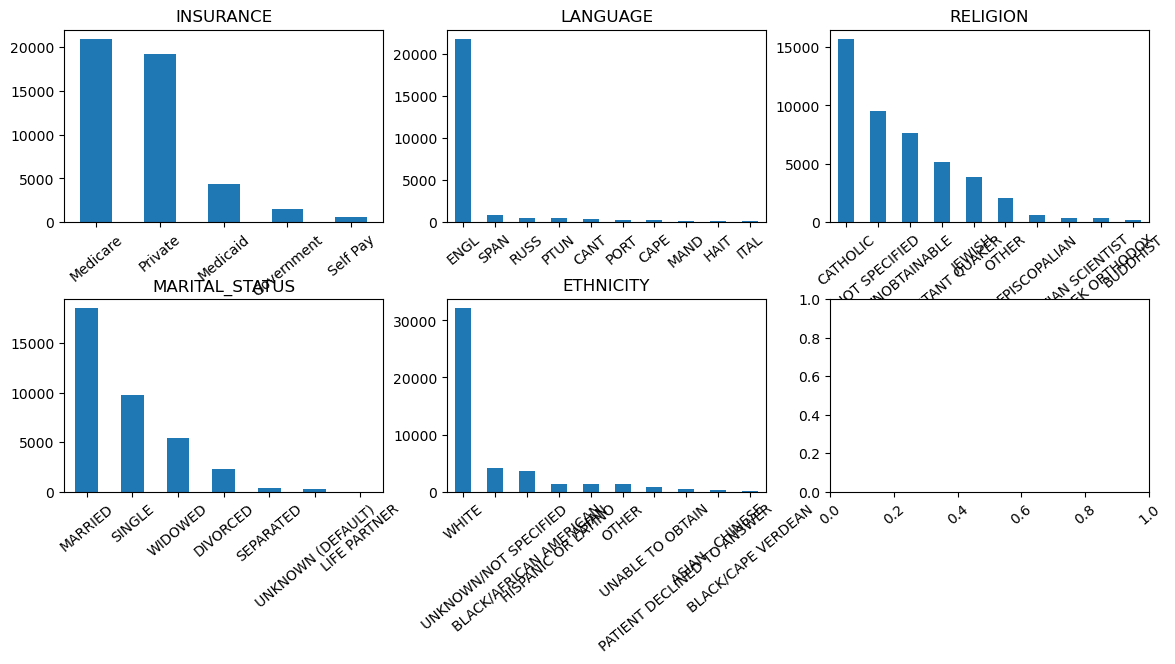

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    patients[col].value_counts()[:10].plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
# rotate xtick labels
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_rotation(40)

# increase distance between subplots
fig.subplots_adjust(hspace=0.4)

<AxesSubplot: >

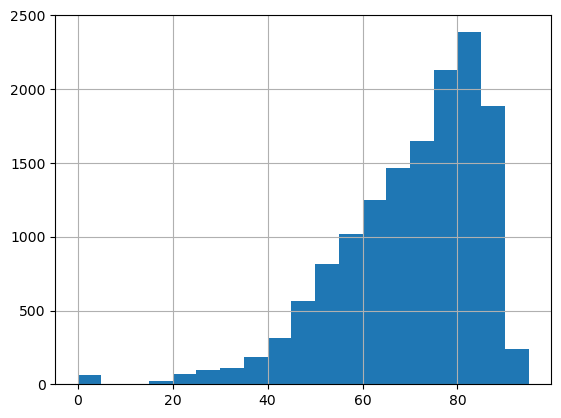

In [124]:
# compute average age of death
patients['death_age'] = patients.DEATHDATE.dt.date - patients.BIRTHDATE.dt.date
death_age = patients[patients.death_age.notnull()]['death_age'].map(lambda x: x.days / 365.25)
death_age.hist(bins=np.arange(0, 100, 5))

## transfers

In [109]:
transfers = pd.read_parquet(join(mimic_path, "concept.transfer.parquet"))
transfers["TIMESTAMP"] = transfers["TIMESTAMP"].dt.date
transfers["TIMESTAMP_END"] = transfers["TIMESTAMP_END"].dt.date

In [118]:
transfers.CONCEPT.value_counts()

TICU          61532
THOSPITAL     58976
TEMERGENCY    30877
Name: CONCEPT, dtype: int64

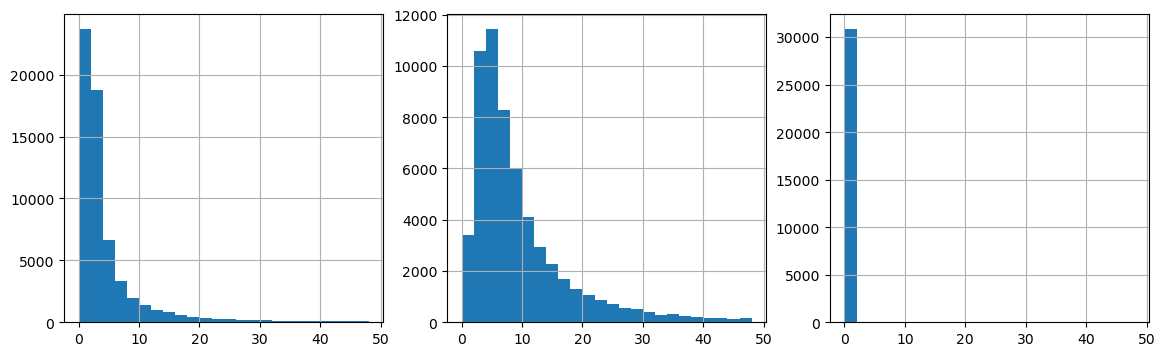

In [123]:
transfers['LOS'] = (transfers.TIMESTAMP_END - transfers.TIMESTAMP).map(lambda x: x.days)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(['TICU', 'THOSPITAL','TEMERGENCY']):
    transfers[transfers.CONCEPT==col]['LOS'].hist(ax=ax[i], bins=np.arange(0,50,2))

We should replace values occuring in less than 1% with a RARE token